In [1]:
# Development cell: it automatically reloads modified code in the various modules
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import numpy as np
import sympy as sp

sp.init_printing()

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

- True population distribution

$$ X_i \sim p_\text{T}(x) = \mathcal{N}(0,1)$$

- Measurements distribution

$$ X_i^{(m)} \sim p_m(x) = p(x^{(m)} | x) = \mathcal{N}(x^{(m)}, \mu=x,\sigma=\sigma_\text{N})$$

- Model

$$ p(x | \vec{w}) = \sum_{i=1}^{N_w} w_i \delta(x - \hat{x}_i)$$

- We would like to understand which are the most probable weights given the data

$$ p(\vec{w} | \{x_i^{(m)}\}) \propto p(\{x_i^{(m)}\} | \vec{w})\; p(\vec{w})$$

- The right thing to do would be to sample $\vec{w}$ according to $p(\vec{w} | \{x_i^{(m)}\})$
- Alternatively

$$\vec{w}_\text{MAP} = \argmax_{\vec{w}} p(\vec{w} | \{x_i^{(m)}\})$$

- Study the distribution

$$ p(x)_\text{MAP} = p(x | \vec{w}_\text{MAP}) = \sum_{i=1}^{N_w} w_{(\text{MAP}), i} \delta(x - \hat{x}_i)$$

- Let's introduce the moments

$$ p(\vec{w}, \vec{m} | \{x_i^{(m)}\}) \propto p(\{x_i^{(m)}\} | \vec{w})\; p(\vec{w} | \vec{m})\;p(\vec{m})$$

- One could use the maximum entropy principle and maximize the entropy of the above expression subject to contraints

$$ \langle \log p(\vec{w}, \vec{m} | \{x_i^{(m)}\})\rangle_p \propto \langle \log p(\{x_i^{(m)}\} | \vec{w}) \rangle_p + \langle \log p(\vec{w} | \vec{m}) \rangle_p + \langle \log p(\vec{m}) \rangle_p + \sum_k \lambda_k \left(\sum_{i=1}^{N_w} w_i \hat{x}_i^k - m_k\right)$$

- For now we use 

$$ p(\{x_i^{(m)}\} | \vec{w}) = \int \text{d} x\, p(\{x_i^{(m)}\}, x | \vec{w}) = \prod_{i=1}^N \int \text{d} x\, p(x_i^{(m)} | x)\; p(x | \vec{w}) = \prod_{i=1}^N \sum_{j=1}^{N_w} w_j p(x_i^{(m)}| \hat{x}_j) = \prod_{i=1}^N \sum_{j=1}^{N_w} L_{ij} w_j$$

$$ p(\vec{w}, \vec{m} | \{x_i^{(m)}\}) \propto \prod_{i=1}^N \left[\sum_{j=1}^{N_w} L_{ij} w_j\right]\; p(\vec{w} | \vec{m})\;p(\vec{m})$$


In [ ]:
from scipy.stats import norm

N, M = 2 ** 8, 2 ** 0
sigma_noise = 2

p_true = lambda x: norm.pdf(x, loc=0, scale=1)
p_measure = lambda x, x_t: norm.pdf(x, loc=x_t, scale=sigma_noise)

X_true = np.random.normal(loc=0, scale=1, size=N)
X_measure = np.array([np.random.normal(loc=x, scale=sigma_noise, size=M) for x in X_true])

N_w = 2 ** 3
x_hat = np.linspace(np.amin(X_measure), np.amax(X_measure), N_w)
L_ij = np.array([[p_measure(X_measure.ravel()[i], x_hat[j]) for j in range(N_w)] for i in range(N * M)])

In [23]:
w_j = np.array([1 / N_w] * N_w)

L_ij @ w_j

array([0.06231157, 0.06232948, 0.06234734, 0.06234699, 0.06234159,
       0.06233994, 0.06229312, 0.06234402, 0.06234213, 0.06183791,
       0.06047482, 0.06221361, 0.06102443, 0.06233848, 0.0616576 ,
       0.06220348, 0.06234786, 0.06224831, 0.06234534, 0.06219512,
       0.05324787, 0.06228007, 0.06227749, 0.06064663, 0.06231723,
       0.06233338, 0.06229521, 0.06234631, 0.06234898, 0.06231286,
       0.06233927, 0.06234309, 0.06082552, 0.06226823, 0.0601564 ,
       0.06224803, 0.0623489 , 0.06208822, 0.06231669, 0.0623014 ,
       0.06234131, 0.06234002, 0.06228694, 0.06122727, 0.0619285 ,
       0.06129782, 0.06184832, 0.06222852, 0.06234171, 0.0623487 ,
       0.0623458 , 0.06234052, 0.06234898, 0.06224287, 0.06155906,
       0.06103153, 0.06234326, 0.06229032, 0.06230448, 0.06234791,
       0.06234509, 0.06233316, 0.06131726, 0.06228221, 0.06233382,
       0.06234884, 0.06234861, 0.06189974, 0.06234792, 0.06234806,
       0.06226581, 0.06185145, 0.05960177, 0.06233847, 0.06234

In [13]:
norm.pdf(0, loc=0, scale=1)

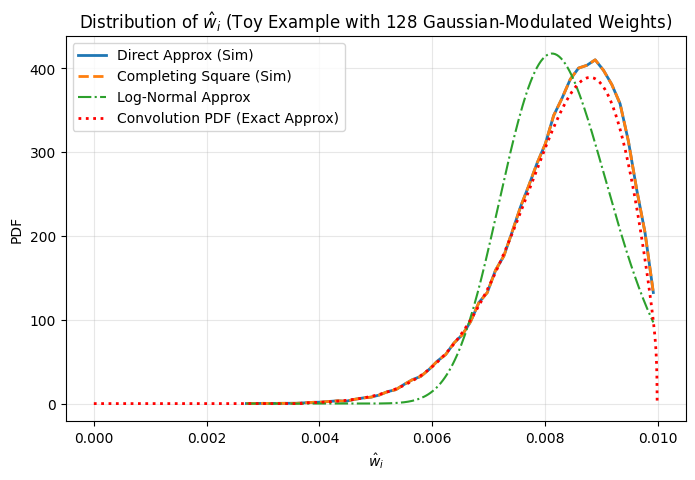

Mean (approx/sim): 0.0083, LogNormal: 0.0083
Mean from Convolution PDF: 0.0079
Variance (sim): 0.0000


/var/folders/3g/6467c3g52dn64pw8v_hyf4nm0000gn/T/ipykernel_56150/1873496482.py:123: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  print(f"Mean from Convolution PDF: {np.trapz(y_grid * pdf_y, y_grid):.4f}")


In [29]:
import numpy as np
from scipy.stats import lognorm, ncx2
from scipy.signal import convolve
import matplotlib.pyplot as plt

# Updated toy parameters for m=128 weights modulated by Gaussian
dim = 2
m = 128
C = np.array([[0.1, 0.05], [0.05, 0.1]])
np.random.seed(42)  # For reproducibility
logits = np.random.randn(m)  # Standard Gaussian logits for weights
w = np.exp(logits) / np.sum(np.exp(logits))  # Softmax normalization
c = np.random.randn(m, dim) * 0.8  # Random c_j scaled to keep variances ~0.1-0.2
c_i = c[0]  # Focus on i=0
w_i = w[0]

# Compute A
A = np.zeros((dim, dim))
for j in range(m):
    A += w[j] * np.outer(c[j], c[j])

# Log-normal params (leading order)
var_xi = c_i @ C @ c_i
tr_ac = np.trace(A @ C)
mu_ln = np.log(w_i) - 0.5 * tr_ac
sigma_ln = np.sqrt(var_xi)

# Completing square
A_inv = np.linalg.inv(A)
shift = A_inv @ c_i
K = np.log(w_i) + 0.5 * c_i @ shift

# Simulation
nsamples = 100000
phi_samples = np.random.multivariate_normal(np.zeros(dim), C, nsamples)

# Direct approx: Need to compute xi_i and full Z approx, but for log approx as before
xi = phi_samples @ c_i
phi_A_phi = np.sum((phi_samples @ A) * phi_samples, axis=1)
log_wh_approx = np.log(w_i) + xi - 0.5 * phi_A_phi
w_hat_approx = np.exp(log_wh_approx)

# Completing square
psi = phi_samples - shift
Q = np.sum((psi @ A) * psi, axis=1)
log_wh_complete = K - 0.5 * Q
w_hat_complete = np.exp(log_wh_complete)

# Canonical form + convolution for exact approx PDF (Imhof alternative)
m_shift = -shift  # Note: renamed to avoid conflict with m=128
L = np.linalg.cholesky(C)
B = L.T @ A @ L
evals, P = np.linalg.eigh(B)
b_vec = L.T @ A @ m_shift
nu = P.T @ b_vec
delta = (nu / evals)**2
const_adjust = m_shift @ A @ m_shift
for k in range(dim):
    const_adjust -= nu[k]**2 / evals[k]
K_prime = K - 0.5 * const_adjust
g = np.exp(K_prime)

# Compute mean_S, var_S for grid sizing
mean_S = np.sum(evals * (1 + delta))
var_S = 2 * np.sum(evals**2 * (1 + 2*delta))
tmax = mean_S + 6 * np.sqrt(var_S)
num_points = 2000
grid = np.linspace(0, tmax, num_points)
dt = grid[1] - grid[0]

def pdf_single(t_grid, lam, del_t):
    pdf = np.zeros_like(t_grid)
    mask = t_grid >= 0
    pdf[mask] = ncx2.pdf(t_grid[mask] / lam, 1, del_t) / lam
    return pdf

pdf1 = pdf_single(grid, evals[0], delta[0])
pdf2 = pdf_single(grid, evals[1], delta[1])

# Convolve
conv = np.convolve(pdf1, pdf2, mode='full')
conv_len = len(conv)
conv_grid = np.linspace(0, (conv_len-1)*dt, conv_len)
pdf_s = conv * dt
mask = conv_grid <= tmax
pdf_s = pdf_s[mask]
conv_grid = conv_grid[mask]

# Transform to PDF of y = g * exp(-0.5 * S)
y_min = 1e-4 * g  # Avoid log(0)
y_max = g
y_grid = np.linspace(y_min, y_max, num_points)
s_grid = 2 * (np.log(g) - np.log(y_grid))
mask_y = (s_grid >= 0) & (s_grid <= tmax)
pdf_y = np.zeros_like(y_grid)
if np.any(mask_y):
    pdf_s_interp = np.interp(s_grid[mask_y], conv_grid, pdf_s, left=0, right=0)
    pdf_y[mask_y] = pdf_s_interp * (2 / y_grid[mask_y])

# PDF estimation via histogram (density=True for PDF)
bins = 50
counts_approx, bin_edges = np.histogram(w_hat_approx, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
pdf_ln = lognorm.pdf(bin_centers, s=sigma_ln, scale=np.exp(mu_ln))
counts_complete, _ = np.histogram(w_hat_complete, bins=bin_edges, density=True)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, counts_approx, label='Direct Approx (Sim)', linewidth=2)
plt.plot(bin_centers, counts_complete, '--', label='Completing Square (Sim)', linewidth=2)
x_plot = np.linspace(bin_centers[0], bin_centers[-1], 200)
plt.plot(x_plot, lognorm.pdf(x_plot, s=sigma_ln, scale=np.exp(mu_ln)), '-.', label='Log-Normal Approx')
plt.plot(y_grid, pdf_y, ':', label='Convolution PDF (Exact Approx)', linewidth=2, color='red')
plt.xlabel(r'$\hat{w}_i$')
plt.ylabel('PDF')
plt.title('Distribution of $\hat{w}_i$ (Toy Example with 128 Gaussian-Modulated Weights)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Moments
print(f"Mean (approx/sim): {np.mean(w_hat_approx):.4f}, LogNormal: {np.exp(mu_ln + 0.5*sigma_ln**2):.4f}")
print(f"Mean from Convolution PDF: {np.trapz(y_grid * pdf_y, y_grid):.4f}")
print(f"Variance (sim): {np.var(w_hat_approx):.4f}")

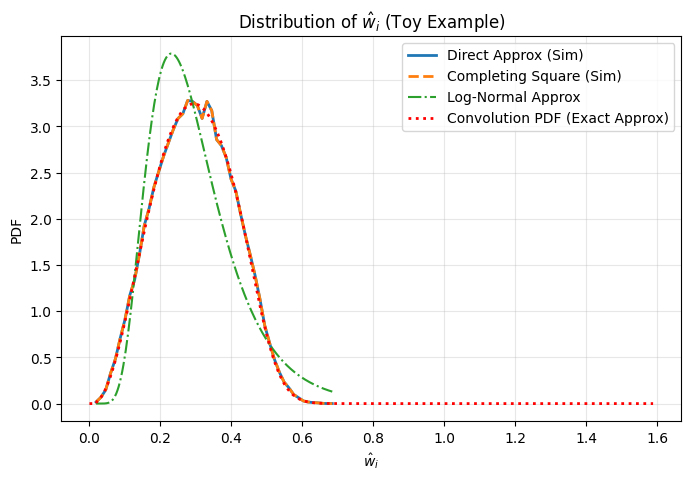

Mean (approx/sim): 0.2979, LogNormal: 0.3000
Mean from Convolution PDF: 0.2957


/var/folders/3g/6467c3g52dn64pw8v_hyf4nm0000gn/T/ipykernel_56150/2705641170.py:117: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  print(f"Mean from Convolution PDF: {np.trapz(y_grid * pdf_y, y_grid):.4f}")


In [27]:
import numpy as np
from scipy.stats import lognorm, ncx2
from scipy.signal import convolve
import matplotlib.pyplot as plt

# Toy parameters (replace with yours)
dim = 2
C = np.array([[0.1, 0.05], [0.05, 0.1]])
c_i = np.array([1.0, 0.5])
w_i = 0.3
w = np.array([0.3, 0.7])
c = np.array([[1.0, 0.5], [0.5, 1.0]])
A = w[0] * np.outer(c[0], c[0]) + w[1] * np.outer(c[1], c[1])

# Log-normal params (leading order)
var_xi = c_i @ C @ c_i
tr_ac = np.trace(A @ C)
mu_ln = np.log(w_i) - 0.5 * tr_ac
sigma_ln = np.sqrt(var_xi)

# Completing square
A_inv = np.linalg.inv(A)
shift = A_inv @ c_i
K = np.log(w_i) + 0.5 * c_i @ shift

# Simulation
np.random.seed(42)
nsamples = 100000
phi_samples = np.random.multivariate_normal(np.zeros(dim), C, nsamples)

# Direct approx
xi = phi_samples @ c_i
phi_A_phi = np.sum((phi_samples @ A) * phi_samples, axis=1)
log_wh_approx = np.log(w_i) + xi - 0.5 * phi_A_phi
w_hat_approx = np.exp(log_wh_approx)

# Completing square
psi = phi_samples - shift
Q = np.sum((psi @ A) * psi, axis=1)
log_wh_complete = K - 0.5 * Q
w_hat_complete = np.exp(log_wh_complete)

# Canonical form + convolution for exact approx PDF (Imhof alternative)
m = -shift
L = np.linalg.cholesky(C)
B = L.T @ A @ L
evals, P = np.linalg.eigh(B)
b_vec = L.T @ A @ m
nu = P.T @ b_vec
delta = (nu / evals)**2
const_adjust = m @ A @ m
for k in range(dim):
    const_adjust -= nu[k]**2 / evals[k]
K_prime = K - 0.5 * const_adjust
g = np.exp(K_prime)

# Compute mean_S, var_S for grid sizing
mean_S = np.sum(evals * (1 + delta))
var_S = 2 * np.sum(evals**2 * (1 + 2*delta))
tmax = mean_S + 6 * np.sqrt(var_S)
num_points = 2000
grid = np.linspace(0, tmax, num_points)
dt = grid[1] - grid[0]

def pdf_single(t_grid, lam, del_t):
    pdf = np.zeros_like(t_grid)
    mask = t_grid >= 0
    pdf[mask] = ncx2.pdf(t_grid[mask] / lam, 1, del_t) / lam
    return pdf

pdf1 = pdf_single(grid, evals[0], delta[0])
pdf2 = pdf_single(grid, evals[1], delta[1])

# Convolve
conv = np.convolve(pdf1, pdf2, mode='full')
conv_len = len(conv)
conv_grid = np.linspace(0, (conv_len-1)*dt, conv_len)
pdf_s = conv * dt
mask = conv_grid <= tmax
pdf_s = pdf_s[mask]
conv_grid = conv_grid[mask]

# Transform to PDF of y = g * exp(-0.5 * S)
y_min = 1e-4 * g  # Avoid log(0)
y_max = g
y_grid = np.linspace(y_min, y_max, num_points)
s_grid = 2 * (np.log(g) - np.log(y_grid))
mask_y = (s_grid >= 0) & (s_grid <= tmax)
pdf_y = np.zeros_like(y_grid)
if np.any(mask_y):
    pdf_s_interp = np.interp(s_grid[mask_y], conv_grid, pdf_s, left=0, right=0)
    pdf_y[mask_y] = pdf_s_interp * (2 / y_grid[mask_y])

# PDF estimation via histogram (density=True for PDF)
bins = 50
counts_approx, bin_edges = np.histogram(w_hat_approx, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
pdf_ln = lognorm.pdf(bin_centers, s=sigma_ln, scale=np.exp(mu_ln))
counts_complete, _ = np.histogram(w_hat_complete, bins=bin_edges, density=True)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, counts_approx, label='Direct Approx (Sim)', linewidth=2)
plt.plot(bin_centers, counts_complete, '--', label='Completing Square (Sim)', linewidth=2)
x_plot = np.linspace(bin_centers[0], bin_centers[-1], 200)
plt.plot(x_plot, lognorm.pdf(x_plot, s=sigma_ln, scale=np.exp(mu_ln)), '-.', label='Log-Normal Approx')
plt.plot(y_grid, pdf_y, ':', label='Convolution PDF (Exact Approx)', linewidth=2, color='red')
plt.xlabel(r'$\hat{w}_i$')
plt.ylabel('PDF')
plt.title('Distribution of $\hat{w}_i$ (Toy Example)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Moments
print(f"Mean (approx/sim): {np.mean(w_hat_approx):.4f}, LogNormal: {np.exp(mu_ln + 0.5*sigma_ln**2):.4f}")
print(f"Mean from Convolution PDF: {np.trapz(y_grid * pdf_y, y_grid):.4f}")

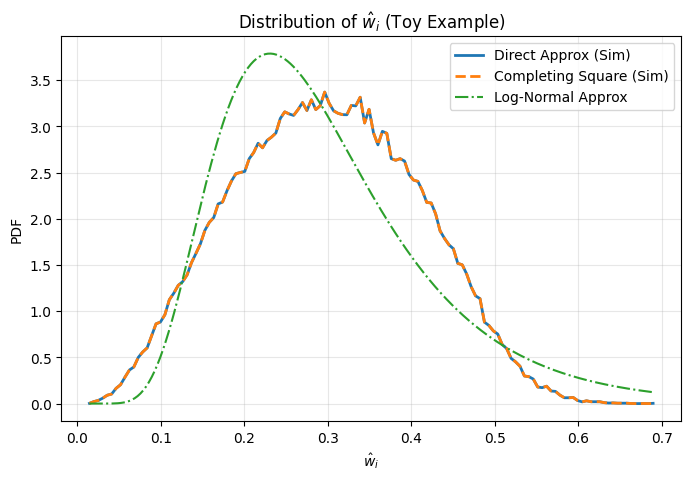

Mean (approx/sim): 0.2982, LogNormal: 0.3000


In [26]:
import numpy as np
from scipy.stats import lognorm
import matplotlib.pyplot as plt

# Toy parameters (replace with yours)
dim = 2
C = np.array([[0.1, 0.05], [0.05, 0.1]])
c_i = np.array([1.0, 0.5])
w_i = 0.3
w = np.array([0.3, 0.7])
c = np.array([[1.0, 0.5], [0.5, 1.0]])
A = w[0] * np.outer(c[0], c[0]) + w[1] * np.outer(c[1], c[1])

# Log-normal params (leading order)
var_xi = c_i @ C @ c_i
tr_ac = np.trace(A @ C)
mu_ln = np.log(w_i) - 0.5 * tr_ac
sigma_ln = np.sqrt(var_xi)

# Completing square
A_inv = np.linalg.inv(A)
shift = A_inv @ c_i
K = np.log(w_i) + 0.5 * c_i @ shift

# Simulation
np.random.seed(42)
nsamples = 2 ** 17
phi_samples = np.random.multivariate_normal(np.zeros(dim), C, nsamples)

# Direct approx
xi = phi_samples @ c_i
phi_A_phi = np.sum((phi_samples @ A) * phi_samples, axis=1)
log_wh_approx = np.log(w_i) + xi - 0.5 * phi_A_phi
w_hat_approx = np.exp(log_wh_approx)

# Completing square
psi = phi_samples - shift
Q = np.sum((psi @ A) * psi, axis=1)
log_wh_complete = K - 0.5 * Q
w_hat_complete = np.exp(log_wh_complete)

# PDF estimation via histogram (density=True for PDF)
bins = 2 ** 7
counts_approx, bin_edges = np.histogram(w_hat_approx, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
pdf_ln = lognorm.pdf(bin_centers, s=sigma_ln, scale=np.exp(mu_ln))
counts_complete, _ = np.histogram(w_hat_complete, bins=bin_edges, density=True)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, counts_approx, label='Direct Approx (Sim)', linewidth=2)
plt.plot(bin_centers, counts_complete, '--', label='Completing Square (Sim)', linewidth=2)
x_plot = np.linspace(bin_centers[0], bin_centers[-1], 200)
plt.plot(x_plot, lognorm.pdf(x_plot, s=sigma_ln, scale=np.exp(mu_ln)), '-.', label='Log-Normal Approx')
plt.xlabel(r'$\hat{w}_i$')
plt.ylabel('PDF')
plt.title('Distribution of $\hat{w}_i$ (Toy Example)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Moments
print(f"Mean (approx/sim): {np.mean(w_hat_approx):.4f}, LogNormal: {np.exp(mu_ln + 0.5*sigma_ln**2):.4f}")